# Script to calculate FUTURE SPEI (multiple models) and drought characteristics

Author: Sarah Chapman

- adapted from Jess Baker's ntoebook
- includes code from Eszter's drought notebook
- adapted 'make_cmip6_filepath' function to accomodate multiple model fpaths
- code to get the institute for each model

Some useful links
https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa

In [335]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import cf_units
import pandas as pd
import copy
import climate_indices
from climate_indices import compute, indices
import iris
from netCDF4 import date2num
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units

import os 

def get_dates(cube, verbose=False):
    dates = cube.coord('time').units.num2date(cube.coord('time').points)
    dates = [dt(date.year, date.month, date.day) for date in dates]
    if verbose is True:
        print(dates)
    else:
        print(dates[0], '–', dates[-1])
    return(dates)

def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range,
                        data_root="/badc/cmip6/data/CMIP6/"):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    # get base path
    path = str(DATA_ROOT / scenario / institute / model / experiment)
    print(path)
    #print(os.listdir(path))
    
    # get path for variant
    if variant is None:
        # select first variant
        dir_list = os.listdir(path)
        variant_list = [x for x in dir_list if x.startswith('r')]
    else:
        variant_list = [variant]
    
    # update path
    var = [x for x in variant_list if x.startswith('r1i1p1')]
    if len(var) == 0:
        print(variant_list)
        var = [x for x in variant_list if x.startswith('r')]
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable)
    else:
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable) 
    print(path)
    # get path for grid
    if grid is None:
        # select first grid (usually only 1)
        dir_list = os.listdir(path)
        grid_list = [x for x in dir_list if x.startswith('g')]
    else:
        grid_list = [grid]
        
    # update path
    path = path + '/' + str(grid_list[0])
    print(path)
    
    # get version path
    if version is None:
        dir_list2 = os.listdir(path)
        version_list = [x for x in dir_list2 if x.startswith('v')]
    else:
        version_list = [version]
    
    # update path
    path = path + '/' + str(version_list[0]) + '/'
    print(path)
    print(os.listdir(path))
    return(path+ '*.nc')

# test
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
model = "UKESM1-0-LL"
expt = 'ssp585'
scenario = 'ScenarioMIP'
fp = make_cmip6_filepath(
        institute="MOHC", scenario=scenario, model=model, experiment=expt, variant=None,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )

/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn/v20190507/
['pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc', 'pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc']


In [2]:
def merge_hist_future_cmip6(hist_cube, future_cube):
    # combine hist and future data into single cube
    hist_dates = get_dates(hist_cube)
    calendar = 'gregorian'
    units = 'days since ' + str(hist_dates[0].year) + '-01-01 00:00:0.0'
    
    future_dates = get_dates(future_cube)
    
    if future_dates[0].year <= hist_dates[-1].year:
        # if future and historical cubes overlap remove overlap
        print(hist_dates[0].year)
        print(future_dates[0].year)
        hist_constraint = iris.Constraint(time=lambda cell: hist_dates[0].year <= cell.point.year < future_dates[0].year)
        hist_cube = hist_cube.extract(hist_constraint)
        hist_dates = get_dates(hist_cube)
        
    dates = hist_dates + future_dates
    
    # get time dimension
    times = date2num(dates, units=units, calendar=calendar)
    time_unit = cf_units.Unit(units, calendar=calendar)
    time = iris.coords.DimCoord(times, standard_name='time',
                                units=time_unit)

    lats = future_cube.coord('latitude').points
    latitude = iris.coords.DimCoord(lats, standard_name='latitude',
                                    units='degrees')
    lons = future_cube.coord('lon').points
    longitude = iris.coords.DimCoord(lons, standard_name='longitude',
                                     units='degrees')
    new_data = np.zeros((len(dates), len(lats), len(lons)))
    
    # add historical data
    new_data[0:hist_cube.shape[0], :, :] = hist_cube.data
    new_data[hist_cube.shape[0]:, :, :] = future_cube.data
    
    # Put data into data cube
    cube = iris.cube.Cube(new_data, var_name=future_cube.standard_name,
                          units=future_cube.units,
                          dim_coords_and_dims=[(time, 0), (latitude, 1),
                                               (longitude, 2)])
    print(cube)
    return(cube)

In [3]:
# create dictionary of models and institutes
basepath = '/badc/cmip6/data/CMIP6/CMIP/'
institute_list = os.listdir(basepath)
model_inst_dict = {}

# loop over institutes
for inst in institute_list:
    model_list = os.listdir(basepath + inst + '/')
    
    # for each institute list models and store in dictionary
    for model_temp in model_list:
        model_inst_dict[model_temp] = inst
        #print(model_inst_dict)
        #assert False
    
    # correction for UKESM which is used by multiple centres - we want MOHC only
    model_inst_dict['UKESM1-0-LL'] = 'MOHC'
#print(os.listdir(path))
print(model_inst_dict)

{'TaiESM1': 'AS-RCEC', 'UKESM1-0-LL': 'MOHC', 'AWI-CM-1-1-MR': 'AWI', 'AWI-ESM-1-1-LR': 'AWI', 'BCC-CSM2-MR': 'BCC', 'BCC-ESM1': 'BCC', 'CAMS-CSM1-0': 'CAMS', 'CAS-ESM2-0': 'CAS', 'FGOALS-f3-L': 'CAS', 'FGOALS-g3': 'CAS', 'IITM-ESM': 'CCCR-IITM', 'CanESM5': 'CCCma', 'CanESM5-CanOE': 'CCCma', 'CMCC-CM2-HR4': 'CMCC', 'CMCC-CM2-SR5': 'CMCC', 'CMCC-ESM2': 'CMCC', 'CNRM-CM6-1': 'CNRM-CERFACS', 'CNRM-CM6-1-HR': 'CNRM-CERFACS', 'CNRM-ESM2-1': 'CNRM-CERFACS', 'ACCESS-ESM1-5': 'CSIRO', 'ACCESS-CM2': 'CSIRO-ARCCSS', 'E3SM-1-0': 'E3SM-Project', 'E3SM-1-1': 'E3SM-Project', 'E3SM-1-1-ECA': 'E3SM-Project', 'EC-Earth3': 'EC-Earth-Consortium', 'EC-Earth3-AerChem': 'EC-Earth-Consortium', 'EC-Earth3-CC': 'EC-Earth-Consortium', 'EC-Earth3-LR': 'EC-Earth-Consortium', 'EC-Earth3-Veg': 'EC-Earth-Consortium', 'EC-Earth3-Veg-LR': 'EC-Earth-Consortium', 'EC-Earth3P-VHR': 'EC-Earth-Consortium', 'FIO-ESM-2-0': 'FIO-QLNM', 'MPI-ESM-1-2-HAM': 'HAMMOZ-Consortium', 'INM-CM4-8': 'INM', 'INM-CM5-0': 'INM', 'IPSL-CM5A2

In [336]:
assert False
# useful guide here: https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_02_Xarray_subset_slicing_plot_CMIP6.html
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
pr_datasets = {}
tas_datasets = {}
expt = 'ssp585'
scenario = 'ScenarioMIP'

# read in monthly data
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5',
          'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM',
          'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8',
          'MPI-ESM1-2-LR', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'] 

# models without SSP585 pr OR tas or have issues with data ('MRI-ESM2-0', )
# 'BCC-ESM1', 'CESM2', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'NorCPM1', 'MRI-ESM2-0', 

#for model in ["HadGEM3-GC31-LL"]:
#for model in ['UKESM1-0-LL']:
#for model in ['FGOALS-g3']:
for model in models:
    print(model)
    institute = model_inst_dict[model]
    
    if model in ['UKESM1-0-LL']:  #something wrong with UKESM r1i1p1 variant (hdf error)
        variant = 'r2i1p1f2'
    else:
        variant = None
    
    # get historical precip data
    fp_hist = make_cmip6_filepath(
        institute=institute, scenario='CMIP', model=model, experiment='historical', variant=variant,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )
    hist_pr_cube = xr.open_mfdataset(fp_hist)
    hist_pr_cube = hist_pr_cube.assign_coords(lon=(((hist_pr_cube.lon + 180) % 360) - 180)).sortby('lon') # change lons from 0,360 to -180,180
    
    # select data over Ghana and convert to Iris cube
    hist_ghana_pr = hist_pr_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
    hist_ghana_pr = hist_ghana_pr.pr.to_iris()
    
    fp_future = make_cmip6_filepath(
        institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )
    
    future_pr_cube = xr.open_mfdataset(fp_future)
    future_pr_cube = future_pr_cube.assign_coords(lon=(((future_pr_cube.lon + 180) % 360) - 180)).sortby('lon') # change lons from 0,360 to -180,180
    
    # select data over Ghana and convert to Iris cube
    future_ghana_pr = future_pr_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
    future_ghana_pr = future_ghana_pr.pr.to_iris()
    
    # combine hist and future precip data into single cube
    cube = merge_hist_future_cmip6(hist_ghana_pr, future_ghana_pr)
    
    pr_datasets[model] = cube
    
    # repeat for tas
    fp_hist = make_cmip6_filepath(
        institute=institute, scenario='CMIP', model=model, experiment='historical', variant=variant,
        table_id="Amon", variable="tas", grid=None, version=None, time_range="*"
    )
    hist_tas_cube = xr.open_mfdataset(fp_hist)
    
    # change longitudes from 0,360 to -180,180
    hist_tas_cube = hist_tas_cube.assign_coords(lon=(((hist_tas_cube.lon + 180) % 360) - 180)).sortby('lon')
    
    # select data over Ghana
    hist_ghana_tas = hist_tas_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
    hist_ghana_tas = hist_ghana_tas.tas.to_iris()
    
    fp_future = make_cmip6_filepath(
        institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
        table_id="Amon", variable="tas", grid=None, version=None, time_range="*"
    )
    
    future_tas_cube = xr.open_mfdataset(fp_future)
    
    # change longitudes from 0,360 to -180,180
    future_tas_cube = future_tas_cube.assign_coords(lon=(((future_tas_cube.lon + 180) % 360) - 180)).sortby('lon')
    
    # select data over Ghana
    future_ghana_tas = future_tas_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
    future_ghana_tas = future_ghana_tas.tas.to_iris()
    
    # combine hist and future data into single cube
    cube = merge_hist_future_cmip6(hist_ghana_tas, future_ghana_tas)
    
    tas_datasets[model] = cube
    #assert False
outpath = '/home/users/train008/data/'
np.save(outpath + 'hist_plus_' + expt + '_ghana_pr_dict.npy', pr_datasets)
np.save(outpath + 'hist_plus_' + expt + '_ghana_tas_dict.npy', tas_datasets)

AssertionError: 

In [337]:
# load dictionaries saved in previous cell
path = '/home/users/train008/data/'
pr_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_pr_dict.npy').item()
tas_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_tas_dict.npy').item()
print(pr_datasets.keys())

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM', 'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'])


In [338]:
#set up variables
# convert to iris cube and extract lat and lon arrays
time_constraint = iris.Constraint(time=lambda cell: 1980 <= cell.point.year <= 2100)
constraint_lon = iris.Constraint(longitude = lambda cell: 6 <= cell.point < 8)
constraint_lat = iris.Constraint(latitude = lambda cell: -3 <= cell.point < 1)
constraint = time_constraint  & constraint_lon & constraint_lat 

# convert to iris cube and extract lat and lon arrays

pr_temp = pr_datasets["HadGEM3-GC31-MM"].extract(time_constraint)
print(pr_temp)

lon = pr_temp.coord('longitude').points
lat = pr_temp.coord('latitude').points

dates = get_dates(pr_temp)
startyear = dates[0].year
calib_year_init = startyear
calib_year_final = 2010

precipitation_flux / (kg m-2 s-1)   (time: 1452; latitude: 13; longitude: 5)
     Dimension coordinates:
          time                           x               -              -
          latitude                       -               x              -
          longitude                      -               -              x
1980-01-16 00:00:00 – 2100-12-16 00:00:00


In [ ]:
#assert False
spei_dict = {}
spei_north_dict = {}
spei_south_dict = {}

for key in [x for x in pr_datasets.keys()][:]:
    print(key)
    if key in ['MRI-ESM2-0']:
        print(key, ' SKIPPED!')
        # issue with time coordinate
        continue
        
    print(key)
    #print(tas_datasets[key])
    
    pr_temp = pr_datasets[key].extract(time_constraint)
    tas_temp = tas_datasets[key].extract(time_constraint)
    dims = pr_temp.shape


    pr_ds = pr_datasets[key]
    pr_ds = pr_ds.extract(time_constraint)
    print(pr_ds.shape)
    #print(pr_ds)
    pr_ds.convert_units('kg m-2 day-1')
    print(pr_ds.coord('latitude').points)
    
    tas_ds = tas_datasets[key]
    tas_ds = tas_ds.extract(time_constraint)
    print(tas_ds.shape)
    #print(tas_ds)
    tas_ds.convert_units('Celsius')
    print(tas_ds.coord('latitude').points)
    
     #save north and south
    pr_north = pr_ds.extract(iris.Constraint(latitude = lambda cell: cell >= 8.0))
    pr_south = pr_ds.extract(iris.Constraint(latitude = lambda cell: cell <= 8.0))
    tas_north = tas_ds.extract(iris.Constraint(latitude = lambda cell: cell >= 8.0))
    tas_south = tas_ds.extract(iris.Constraint(latitude = lambda cell: cell <= 8.0))

    try:
        pr_nmean = pr_north.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        pr_smean = pr_south.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        pr_mean = pr_ds.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        
        tas_nmean = tas_north.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        tas_smean = tas_south.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        tas_mean = tas_ds.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    except:
        print('no longitude, latitude')

    try:
        pr_nmean = pr_north.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        pr_smean = pr_south.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        pr_mean = pr_ds.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        
        tas_nmean = tas_north.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        tas_smean = tas_south.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        tas_mean = tas_ds.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
    except:
        print('no lon, latitude')

    
    #print(dims)
    
    #create cubes for storing data
    spei_cube = copy.deepcopy(pr_mean)  #np.array((pr_temp.shape))
    pet_cube = copy.deepcopy(pr_mean)   #np.array((pr_temp.shape))
    
    spei_ncube = copy.deepcopy(pr_nmean)  #np.array((pr_temp.shape))
    pet_ncube = copy.deepcopy(pr_nmean)   #np.array((pr_temp.shape))
    
    spei_scube = copy.deepcopy(pr_smean)  #np.array((pr_temp.shape))
    pet_scube = copy.deepcopy(pr_smean)   #np.array((pr_temp.shape))
    
    #calculate SPEI
    temp_lat = pr_mean.coord('latitude').points[0]
    temp_nlat = pr_nmean.coord('latitude').points[0]
    temp_slat = pr_smean.coord('latitude').points[0]

    #calculate pet
    pet = indices.pet(tas_mean.data, temp_lat, startyear)
    pet_cube.data = pet
    
    pet = indices.pet(tas_nmean.data, temp_nlat, startyear)
    pet_ncube.data = pet
    
    pet = indices.pet(tas_smean.data, temp_slat, startyear)
    pet_scube.data = pet

    #calculate spei
    kwargs = dict(
        precips_mm = pr_mean.data,
        pet_mm = pet_cube.data,
        scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
        distribution = indices.Distribution.gamma,
        periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
        data_start_year = startyear,
        calibration_year_initial = calib_year_init,
        calibration_year_final = calib_year_final,
        fitting_params=None
    )
    spei = indices.spei(**kwargs)

    spei_cube.data = spei
    
    #calculate spei
    kwargs = dict(
        precips_mm = pr_nmean.data,
        pet_mm = pet_ncube.data,
        scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
        distribution = indices.Distribution.gamma,
        periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
        data_start_year = startyear,
        calibration_year_initial = calib_year_init,
        calibration_year_final = calib_year_final,
        fitting_params=None
    )
    spei = indices.spei(**kwargs)

    spei_ncube.data = spei
    
    #calculate spei
    kwargs = dict(
        precips_mm = pr_smean.data,
        pet_mm = pet_scube.data,
        scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
        distribution = indices.Distribution.gamma,
        periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
        data_start_year = startyear,
        calibration_year_initial = calib_year_init,
        calibration_year_final = calib_year_final,
        fitting_params=None
    )
    spei = indices.spei(**kwargs)

    spei_scube.data = spei
    
    #assert False
            
        
        
    spei_dict[key] = spei_cube

    spei_north_dict[key] = spei_ncube
    spei_south_dict[key] = spei_scube

    
outpath = '/home/users/train008/data/'
print(outpath + 'hist_'+expt+'_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy')
np.save(outpath+ 'hist_'+expt+'_ghana_meanspei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy', spei_dict)
np.save(outpath+ 'hist_'+expt+'_ghana_meannorth_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy', spei_north_dict)
np.save(outpath+ 'hist_'+expt+'_ghana_meansouth_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy', spei_south_dict)

In [142]:
# load dicts save in previous cell
path = '/home/users/train008/data/'
expt = 'ssp585'
spei_dict = np.load(path+ 'hist_'+expt+'_ghana_meanspei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy').item()
spei_north_dict = np.load(path+ 'hist_'+expt+'_ghana_meannorth_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy').item()
spei_south_dict = np.load(path+ 'hist_'+expt+'_ghana_meansouth_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_2.npy').item()

path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/spei_output/'
expt = 'ssp119'
spei_dict_119 = np.load(path+ 'hist_'+expt+'_all_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()
spei_north_dict_119 = np.load(path+ 'hist_'+expt+'_n_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()
spei_south_dict_119 = np.load(path+ 'hist_'+expt+'_s_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib.npy').item()


In [155]:
def cube_to_frame(cube_dict, expt='hist', region = 'all'): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value', 'region'])
    
    for key in cube_dict.keys():
        cube = cube_dict[key].copy()
        
        if expt == 'ssp119':
            cube = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
            
        #cube_time_mean = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        model = key #extract from attributes later
        
        #print(cube)
        x = cube.data
        x = x.flatten() #if masked to land sea, which isn't as moment
        
        iris.coord_categorisation.add_year(cube, 'time', name='year')
        iris.coord_categorisation.add_month(cube, 'time', name='month')
        
        year =  cube.coord('year').points
        #print(year)
        month = cube.coord('month').points
        
        y = pd.DataFrame(columns =   ['model', 'expt', 'year', 'month', 'value', 'region'])
       
        y['value'] = x
        y['year'] = year
        y['model'] = model
        y['expt'] = expt
        y['month'] = month
        y['region'] = region
        
        df= df.append(y)
    
    return(df)

In [155]:
#calculate avg pr and temp in Ghana in future

path = '/home/users/train008/data/'
pr_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_pr_dict.npy').item()
tas_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_tas_dict.npy').item()
print(pr_datasets.keys())

In [156]:
#create dataframe for all regions
df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value', 'region'])
dict_list = [spei_dict, spei_north_dict, spei_south_dict,
            spei_dict_119, spei_north_dict_119, spei_south_dict_119]
reg_list = ['all', 'north', 'south', 'all', 'north', 'south']
exp = ['ssp585', 'ssp585', 'ssp585', 'ssp119', 'ssp119', 'ssp119']
for i in np.arange(len(dict_list)):
    d = dict_list[i]
    r = reg_list[i]
    expt = exp[i]
    y = cube_to_frame(d, expt = expt, region = r)
    df = df.append(y)
    

In [228]:
df_his = df[df['year'] <= 2010] 
df_his = df_his[df_his['expt'] == 'ssp119'] # slightly different historical resulst based on scenario. 
                                            # Going for lower scenario as only minor difference but otherwise intensity of droughts decreases with climate change
df_mid = df[(df['year'] <= 2050) & (df['year'] > 2010)] # after this temperature gets too high so can't get meaningful results (it's always a drought)

## Calculate drought characteristics

### Drought intensity

In [229]:
##number of months SPEI <= -3
expts = ['ssp585', 'ssp119']
regions = ['all', 'north', 'south']

#historical
df_his_list = []
df_his1_list = []
df_his3_list = []

df_his1 = df_his[df_his['value'] <= -1]
df_his3 = df_his[df_his['value'] <= -3]

for r in regions:
        new_df_r = df_his[df_his['region'] == r]
        df_his1_r = df_his1[df_his1['region'] == r]
        df_his3_r = df_his3[df_his3['region'] == r]
   
        df_his_list.append(new_df_r)
        df_his1_list.append(df_his1_r)
        df_his3_list.append(df_his3_r)

        
#mid-century

df_mid_list = []
df_mid1_list = []
df_mid3_list = []
for x in expts:
    new_df = df_mid[df_mid['expt'] == x]
    df_mid1 = new_df[new_df['value'] <= -1]
    df_mid3 = new_df[new_df['value'] <= -3]
    
    for r in regions:
        new_df_r = new_df[new_df['region'] == r]
        df_mid1_r = df_mid1[df_mid1['region'] == r]
        df_mid3_r = df_mid3[df_mid3['region'] == r]
   
    
        df_mid_list.append(new_df_r)
        df_mid1_list.append(df_mid1_r)
        df_mid3_list.append(df_mid3_r)
        
        
  

In [295]:
#cycle through region dfs and get average intensity

avg_int_list = []
avg_ci_list = []

for i in np.arange(len(df_his1_list)):
    df_his_agg = df_his1_list[i].groupby(['model', 'expt'])['value'].mean() # get mean across each model
    avg_int = np.nanmean(df_his_agg.values) # get ens mean
    avg_int_list.append(avg_int)
    
    #CI
    ci = np.nanpercentile(df_his1_list[i]['value'], q = [5, 95])
    avg_ci_list.append(ci)

n_3_his_list = []
n_3_ci_his_list = []

for i in np.arange(len(df_his3_list)):
    df_his_agg = df_his3_list[i].groupby(['model', 'expt', 'region'])['value'].count()
    n_3_his = np.nanmean(df_his_agg.values)

    nyears = len(np.unique(df_his_list[0]['year'])) # number of years for mid time period

    per_month_his = n_3_his / (nyears * 12) * 100
        
    #confidence intervals
    ci = np.nanpercentile(df_his_agg.values, q = [5, 95])
    
    if len(df_his_agg.values) == 0:
        per_month_his = 0
        ci = [0,0]
    
    n_3_his_list.append(per_month_his)
    n_3_ci_his_list.append(ci)

print('Across all of Ghana, the average intensity of droughts in the present day is:', np.round(np.nanmean(avg_int_list[0]), 1))
print('Across all of Ghana, the % of months which count as extreme in the present day is:', np.round(np.nanmean(n_3_his_list[0]), 1))


Across all of Ghana, the average intensity of droughts in the present day is: -1.3
Across all of Ghana, the % of months which count as extreme in the present day is: 0.0


In [300]:
#future scenario results
avg_int_mid_list = []
avg_int_ci_mid_list = []

for i in np.arange(len(df_mid1_list)):
    df_his_agg = df_mid1_list[i].groupby(['model', 'expt'])['value'].mean()
    avg_int = np.nanmean(df_his_agg.values)
    avg_int_mid_list.append(avg_int)
    
    #CI
    ci = np.nanpercentile(df_mid1_list[i]['value'], q = [5, 95])
    avg_int_ci_mid_list.append(ci)

n_3_mid_list = []
n_3_ci_mid_list = []


for i in np.arange(len(df_mid3_list)):
    df_his_agg = df_mid3_list[i].groupby(['model', 'expt', 'region'])['value'].count()
    n_3_his = np.nanmean(df_his_agg.values)

    nyears = len(np.unique(df_his_list[0]['year'])) # number of years for mid time period

    per_month_his = n_3_his / (nyears * 12) * 100
    
    #confidence intervals
    ci = np.nanpercentile(df_his_agg.values, q = [5, 95])
    ci = ci / (nyears * 12) * 100
    
    
    if len(df_his_agg.values) == 0:
        per_month_his = 0
        ci = [0,0]
    
    n_3_mid_list.append(per_month_his)
    n_3_ci_mid_list.append(ci)


print('Across all of Ghana, the average intensity of droughts, SSP585:', np.round(np.nanmean(avg_int_mid_list[0]), 1))
print('                                                         North:', np.round(np.nanmean(avg_int_mid_list[1]), 1))
print('                                                         South:', np.round(np.nanmean(avg_int_mid_list[2]), 1))
print('Across all of Ghana, the average intensity of droughts, SSP119:', np.round(np.nanmean(avg_int_mid_list[3]), 1))
print('                                                         North:', np.round(np.nanmean(avg_int_mid_list[4]), 1))
print('                                                         South:', np.round(np.nanmean(avg_int_mid_list[5]), 1))

print('Across all of Ghana, the % of months which count as extreme, SSP585:', np.round(np.nanmean(n_3_mid_list[0]), 1))
print('                                                              North:', np.round(np.nanmean(n_3_mid_list[1]), 1))
print('                                                              South:', np.round(np.nanmean(n_3_mid_list[2]), 1))
print('Across all of Ghana, the % of months which count as extreme, SSP119:', np.round(np.nanmean(n_3_mid_list[3]), 1))
print('                                                              North:', np.round(np.nanmean(n_3_mid_list[4]), 1))
print('                                                              South:', np.round(np.nanmean(n_3_mid_list[5]), 1))


Across all of Ghana, the average intensity of droughts, SSP585: -2.3
                                                         North: -2.3
                                                         South: -2.4
Across all of Ghana, the average intensity of droughts, SSP119: -1.3
                                                         North: -1.3
                                                         South: -1.3
Across all of Ghana, the % of months which count as extreme, SSP585: 34.2
                                                              North: 27.3
                                                              South: 39.8
Across all of Ghana, the % of months which count as extreme, SSP119: 2.2
                                                              North: 4.3
                                                              South: 2.4


### Drought length

In [254]:
#function to count consectuive values
def count_dur(y):
    x = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
    return x

def calc_drought_length(df):
    
    #add drought column
    df['drought'] = 0
    df['drought'][df['value'] <= -1] = 1

    #cycle through each model and region and calculate length of droughts (consecutive values < -1)
    #split df by model and region (will have to had experiment as well if add ssp8.5 etc)
    mod = np.unique(df['model'])
    reg = np.unique(df['region'])

    drought_df = pd.DataFrame(columns = ['model', 'region', 'mean_dur', 'max_dur', 'num_5_or_more'])
    for m in mod:
        df_mod = df[df['model'] == m]
        for r in reg:
            df_r = df_mod[df_mod['region'] == r]
            df_r['duration'] = count_dur(df_r['drought'])

            #calculate characteristics of model
            x_max = np.nanmax(df_r['duration'])
            mean_dur = np.nanmean(df_r[df_r['duration'] > 0]['duration'])
            df_5 = df_r[df_r['duration'] >= 5]

            new_df = pd.DataFrame({'model': [m],
                                  'region': r,
                                  'mean_dur': mean_dur,
                                  'max_dur': x_max,
                                  'num_5_or_more': len(df_5.index)})

            drought_df = drought_df.append(new_df)
        
    return drought_df

drought_his_list = []
drought_mid_list = []

#order all, north , south
for i in np.arange(len(df_his_list)):
    x = calc_drought_length(df_his_list[i])
    drought_his_list.append(x)

#order ssp585 all north south, then ssp119
for i in np.arange(len(df_mid_list)):
    x = calc_drought_length(df_mid_list[i])
    drought_mid_list.append(x)


In [255]:
#number of times droughts lasting 5 months or more occur for models with droughts lasting longer than 5 months, 
his_x5 = np.nanmean(drought_his[drought_his['num_5_or_more'] > 0 ]['num_5_or_more'].astype('float'))

#mean drought length
his_meandl_list = []
for i in np.arange(len(drought_his_list)):
    x = np.round(np.nanmean(drought_his_list[i]['mean_dur'].astype('float'),0))
    his_meandl_list.append(x)

mid_meandl_list = []
for i in np.arange(len(drought_mid_list)):
    x = np.round(np.nanmean(drought_mid_list[i]['mean_dur'].astype('float'),0))
    mid_meandl_list.append(x)
    

#mean maximum drought length
his_maxdl_list = []
for i in np.arange(len(drought_his_list)):
    x = np.round(np.nanmean(drought_his_list[i]['max_dur'].astype('float'),0))
    his_maxdl_list.append(x)

mid_maxdl_list = []
for i in np.arange(len(drought_mid_list)):
    x = np.round(np.nanmean(drought_mid_list[i]['max_dur'].astype('float'),0))
    mid_maxdl_list.append(x)



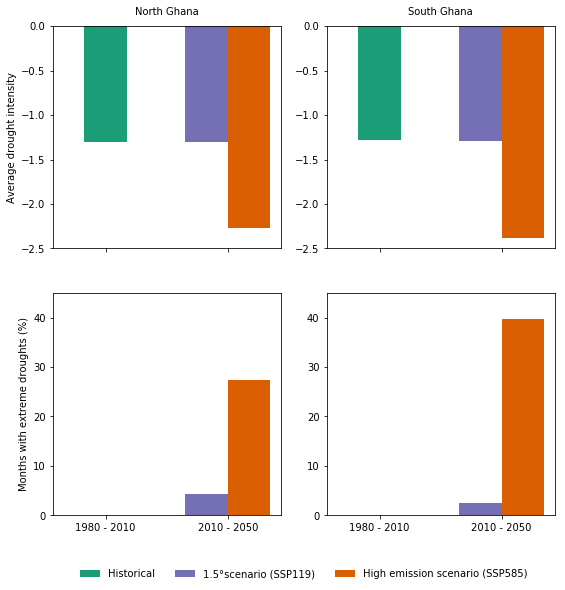

In [332]:
#Plot bar char (drought intensity)
#set up info for bar locations
periods = ['1980 - 2010', '2010 - 2050']
n_periods = len(periods)
y_pos = np.arange(n_periods)
bar_width = 0.35

# set up plotting variables
cols = ['#1b9e77', '#7570b3', '#d95f02']

#set up data
nmeans_his = [avg_int_list[1], 0]
nmeans_85 = [0, avg_int_mid_list[1]]
nmeans_19 = [0, avg_int_mid_list[4]]

nn3_his = [n_3_his_list[1], 0]
nn3_85 = [0, n_3_mid_list[1]]
nn3_19 = [0, n_3_mid_list[4]]

smeans_his = [avg_int_list[2], 0]
smeans_85 = [0, avg_int_mid_list[2]]
smeans_19 = [0, avg_int_mid_list[5]]

sn3_his = [n_3_his_list[2], 0]
sn3_85 = [0, n_3_mid_list[2]]
sn3_19 = [0, n_3_mid_list[5]]

avg_list_north = [nmeans_his, nmeans_19, nmeans_85]
n3_list_north = [nn3_his, nn3_19, nn3_85]
avg_list_south = [smeans_his, smeans_19, smeans_85]
n3_list_south = [sn3_his, sn3_19, sn3_85]

dat_list = [avg_list_north, avg_list_south, 
            n3_list_north, n3_list_south]

#set up ci data
avg_ci_list_north = [avg_ci_list[1], avg_int_ci_mid_list[4], avg_int_ci_mid_list[1]]
n3_ci_list_north = [n_3_ci_his_list[1], n_3_ci_mid_list[4], n_3_ci_mid_list[1]]
avg_ci_list_south = [avg_ci_list[2], avg_int_ci_mid_list[5], avg_int_ci_mid_list[2]]
n3_ci_list_south = [n_3_ci_his_list[2], n_3_ci_mid_list[5], n_3_ci_mid_list[2]]

ci_list = [avg_ci_list_north, avg_ci_list_south, 
            n3_ci_list_north, n3_ci_list_south]



#plot

fig = plt.figure(figsize = (9,9))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax_list = [ax1, ax2, ax3, ax4]

for ax in ax_list:
    ax.set_xticks(y_pos)
    ax.set_xticklabels(periods)
    
ax1.set_ylim(-2.5, 0)
ax2.set_ylim(-2.5, 0)
ax1.set_xticklabels([''] * 2)
ax2.set_xticklabels([''] * 2)

ax3.set_ylim(0, 45)
ax4.set_ylim(0, 45)
ax3.set_yticks(np.arange(0, 50, 10))
ax4.set_yticks(np.arange(0, 50, 10))

for i in np.arange(len(dat_list)):
    ax = ax_list[i]
    plot_df = dat_list[i]
    plot_ci = ci_list[i]
    
    rects1 = ax.bar(y_pos, plot_df[0], bar_width,
                    color = cols[0], label = 'Historical')
    rects2 = ax.bar(y_pos - bar_width/2, plot_df[1], bar_width,
                    color = cols[1], label = '1.5' +  u'\u00B0' + 'scenario (SSP119)')
    rects3 = ax.bar(y_pos + bar_width/2 , plot_df[2], bar_width,
                    color = cols[2], label = 'High emission scenario (SSP585)')
    
    # add CI
    #ax.vlines(x = y_pos[0], ymin = plot_ci[0][0], ymax = plot_ci[0][1], color = 'black')
    #ax.vlines(x = y_pos[1] - bar_width/2, ymin = plot_ci[1][0], ymax = plot_ci[1][1], color = 'black')
    #ax.vlines(x = y_pos[1] + bar_width/2, ymin = plot_ci[2][0], ymax = plot_ci[2][1], color = 'black')

#ax1.set_xlabel('Scenario')
ax1.set_ylabel('Average drought intensity')
ax3.set_ylabel('Months with extreme droughts (%)')

xpos, ypos = 0.5, 1.05
ax1.annotate(s = 'North Ghana', xy = (xpos, ypos), xycoords = 'axes fraction', ha = 'center')
ax2.annotate(s = 'South Ghana', xy = (xpos, ypos), xycoords = 'axes fraction', ha = 'center')


ax3.legend(loc = 'upper center', bbox_to_anchor=(1.1, -0.2), ncol = 3, frameon = False)

#fig.savefig('/home/users/train008/drought_intensity.png', dpi=300, bbox_inches='tight')

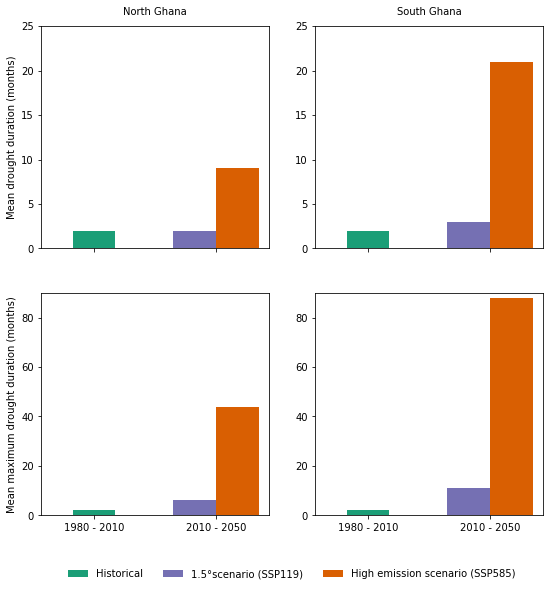

In [333]:
#Plot bar char (drought intensity)
#set up info for bar locations
periods = ['1980 - 2010', '2010 - 2050']
n_periods = len(periods)
y_pos = np.arange(n_periods)
bar_width = 0.35

# set up plotting variables
cols = ['#1b9e77', '#7570b3', '#d95f02']

#set up data
nmeans_his = [his_meandl_list[1], 0]
nmeans_85 = [0, mid_meandl_list[1]]
nmeans_19 = [0, mid_meandl_list[4]]

ndur_his = [his_maxdl_list[1], 0]
ndur_85 = [0, mid_maxdl_list[1]]
ndur_19 = [0, mid_maxdl_list[4]]

smeans_his = [his_meandl_list[2], 0]
smeans_85 = [0, mid_meandl_list[2]]
smeans_19 = [0, mid_meandl_list[5]]

sdur_his = [his_maxdl_list[2], 0]
sdur_85 = [0, mid_maxdl_list[2]]
sdur_19 = [0, mid_maxdl_list[5]]

avg_list_north = [nmeans_his, nmeans_19, nmeans_85]
dur_list_north = [ndur_his, ndur_19, ndur_85]
avg_list_south = [smeans_his, smeans_19, smeans_85]
dur_list_south = [sdur_his, sdur_19, sdur_85]

dat_list = [avg_list_north, avg_list_south, 
            dur_list_north, dur_list_south]

#plot

fig = plt.figure(figsize = (9,9))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax_list = [ax1, ax2, ax3, ax4]

for ax in ax_list:
    ax.set_xticks(y_pos)
    ax.set_xticklabels(periods)
    
ax1.set_ylim(0, 25)
ax2.set_ylim(0, 25)
ax1.set_xticklabels([''] * 2)
ax2.set_xticklabels([''] * 2)

ax3.set_ylim(0, 90)
ax4.set_ylim(0, 90)
ax3.set_yticks(np.arange(0, 100, 20))
ax4.set_yticks(np.arange(0, 100, 20))

for i in np.arange(len(dat_list)):
    ax = ax_list[i]
    plot_df = dat_list[i]
    
    rects1 = ax.bar(y_pos, plot_df[0], bar_width,
                    color = cols[0], label = 'Historical')
    rects2 = ax.bar(y_pos - bar_width/2, plot_df[1], bar_width,
                    color = cols[1], label = '1.5' +  u'\u00B0' + 'scenario (SSP119)')
    rects3 = ax.bar(y_pos + bar_width/2 , plot_df[2], bar_width,
                    color = cols[2], label = 'High emission scenario (SSP585)')

#ax1.set_xlabel('Scenario')
ax1.set_ylabel('Mean drought duration (months)')
ax3.set_ylabel('Mean maximum drought duration (months)')

xpos, ypos = 0.5, 1.05
ax1.annotate(s = 'North Ghana', xy = (xpos, ypos), xycoords = 'axes fraction', ha = 'center')
ax2.annotate(s = 'South Ghana', xy = (xpos, ypos), xycoords = 'axes fraction', ha = 'center')


ax3.legend(loc = 'upper center', bbox_to_anchor=(1.1, -0.2), ncol = 3, frameon = False)

#fig.savefig('/home/users/train008/drought_duration.png', dpi=300, bbox_inches='tight')

In [ ]:
##plot time series

#fig = plt.figure(figsize = (9,6))

#ax =  fig.add_subplot(111)

#turn into dataframe and extract year
#spei_df = cube_to_frame(spei_dict, expt=expt)
#print(spei_df.head(5))
#print(spei_df.tail(5))

for model in np.unique(df_mid['model']):
    #print(model)
    fig = plt.figure(figsize = (9,6))
    ax =  fig.add_subplot(111)
    ax.set_ylim([-3,3])
    #continue
    years =  np.unique(df_mid['year'])
    #print(years)
    #print(df_mid[df_mid.model==model])
   # assert False
    ax.plot(df_mid['value'][df_mid.model==model], label=model)#, c = 'black', label=model)
    ax.set_title(model)
    
    ax.set_xticks(np.arange(0, 1000, 70))
    ax.set_xticklabels(df_mid['year'][::70])
#ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
#ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
#ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.10), ncol = 3, frameon = False)
ax.set_title(expt.upper() + ' SPEI')        
outpath = '/home/users/train008/' + expt + '_spei_multi_model.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')

2556